In [4]:
import cvxportfolio as cvx

In [1]:
# Here we define a class to forecast expected returns
# There is no need to inherit from a base class, in this simple case
class WindowMeanReturns: # pylint: disable=too-few-public-methods
    """Expected return as mean of recent window of past returns.

    This is only meant as an example of how to define a custom forecaster;
    it is not very interesting. Since version ``1.2.0`` a similar
    functionality has been included in the default forecasters classes.

    :param window: Window used for the mean returns.
    :type window: int
    """

    def __init__(self, window=20):
        self.window = window

    def values_in_time(self, past_returns, **kwargs):
        """This method computes the quantity of interest.

        It has many arguments, we only need to use ``past_returns`` in this
        case.

        :param past_returns: Historical market returns for all assets in
            the current trading universe, up to each time at which the
            policy is evaluated.
        :type past_returns: pd.DataFrame
        :param kwargs: Other, unused, arguments to :meth:`values_in_time`.
        :type kwargs: dict

        :returns: Estimated mean returns.
        :rtype: pd.Series

        .. note::

            The last column of ``past_returns`` are the cash returns.
            You need to explicitely skip them otherwise Cvxportfolio will
            throw an error.
        """
        # print("past returns", past_returns.head())
        return past_returns.iloc[-self.window:, :-1].mean()

# Here we define a class to forecast covariances
# There is no need to inherit from a base class, in this simple case
class WindowCovariance: # pylint: disable=too-few-public-methods
    """Covariance computed on recent window of past returns.

    This is only meant as an example of how to define a custom forecaster;
    it is not very interesting. Since version ``1.2.0`` a similar
    functionality has been included in the default forecasters classes.

    :param window: Window used for the covariance computation.
    :type window: int
    """

    def __init__(self, window=20):
        self.window = window

    def values_in_time(self, past_returns, **kwargs):
        """This method computes the quantity of interest.

        It has many arguments, we only need to use ``past_returns`` in this
        case.

        :param past_returns: Historical market returns for all assets in
            the current trading universe, up to each time at which the
            policy is evaluated.
        :type past_returns: pd.DataFrame
        :param kwargs: Other, unused, arguments to :meth:`values_in_time`.
        :type kwargs: dict

        :returns: Estimated covariance.
        :rtype: pd.DataFrame

        .. note::

            The last column of ``past_returns`` are the cash returns.
            You need to explicitely skip them otherwise Cvxportfolio will
            throw an error.
        """
        return past_returns.iloc[-self.window:, :-1].cov()

In [2]:
# define the hyper-parameters
WINDOWMU = 252
WINDOWSIGMA = 252
GAMMA_RISK = 5
GAMMA_TRADE = 3

# define the forecasters
mean_return_forecaster = WindowMeanReturns(WINDOWMU)
covariance_forecaster = WindowCovariance(WINDOWSIGMA)

Updating data

.

YahooFinance update of AAPL is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close   volume    return
2024-05-21 13:30:00+00:00  0.000000  0.0   0.0    0.0  45900.0  0.000105
2024-05-22 13:30:00+00:00  0.020004  NaN   NaN    NaN      NaN       NaN
YahooFinance(AAPL) update changed last open price: stored value was 192.25, new value is 192.27000427246094


.

YahooFinance update of AMZN is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close   volume    return
2024-05-21 13:30:00+00:00  0.000000  0.0   0.0    0.0  54100.0  0.000274
2024-05-22 13:30:00+00:00  0.050003  NaN   NaN    NaN      NaN       NaN
YahooFinance(AMZN) update changed last open price: stored value was 183.8300018310547, new value is 183.8800048828125


.

YahooFinance update of GOOG is not append-only!
Difference between overlap of downloaded and stored:                               open  low  high  close  volume    return
2024-05-21 13:30:00+00:00  0.00000  0.0   0.0    0.0  8900.0 -0.000056
2024-05-22 13:30:00+00:00 -0.01001  NaN   NaN    NaN     NaN       NaN
YahooFinance(GOOG) update changed last open price: stored value was 178.41000366210938, new value is 178.39999389648438


.

YahooFinance update of MSFT is not append-only!
Difference between overlap of downloaded and stored:                            open  low  high  close   volume  return
2024-05-21 13:30:00+00:00   0.0  0.0   0.0    0.0  24600.0     0.0
2024-05-22 13:30:00+00:00   0.0  NaN   NaN    NaN      NaN     NaN


.

YahooFinance update of NVDA is not append-only!
Difference between overlap of downloaded and stored:                                open  low  high  close    volume    return
2024-05-21 13:30:00+00:00  0.000000  0.0   0.0    0.0  136900.0  0.000513
2024-05-22 13:30:00+00:00  0.480042  NaN   NaN    NaN       NaN       NaN
YahooFinance(NVDA) update changed last open price: stored value was 954.1099853515625, new value is 954.5900268554688




#################################################################
Universe size                                                   6
Initial timestamp                       2010-01-04 14:30:00+00:00
Final timestamp                         2024-05-24 13:30:00+00:00
Number of periods                                            3623
Initial value (USDOLLAR)                                1.000e+06
Final value (USDOLLAR)                                  1.441e+07
Profit (USDOLLAR)                                       1.341e+07
                                                                 
Avg. return (annualized)                                    20.7%
Volatility (annualized)                                     20.6%
Avg. excess return (annualized)                             19.6%
Avg. active return (annualized)                             19.6%
Excess volatility (annualized)                              20.6%
Active volatility (annualized)                              20.6%
        

/Users/jacktang/miniconda3/envs/dev/lib/python3.11/site-packages/cvxportfolio/result.py:993: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # pragma: no cover


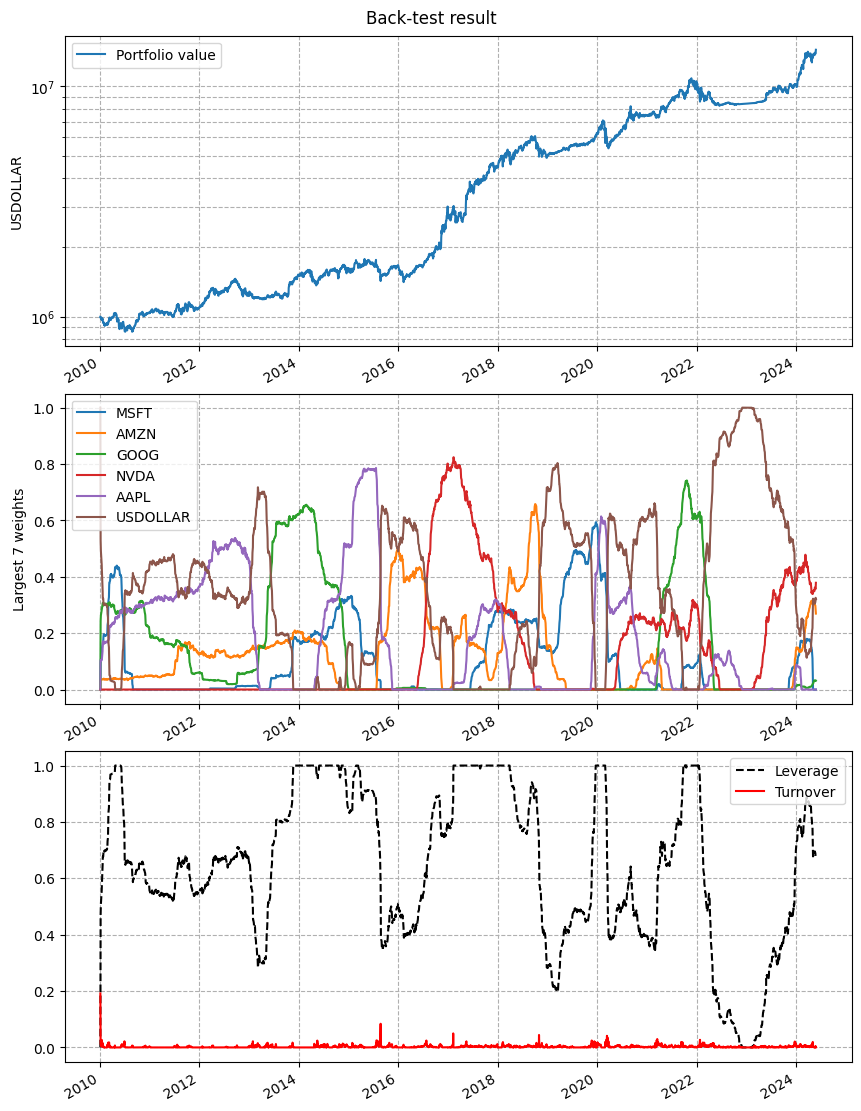

In [5]:


# define the policy
policy = cvx.SinglePeriodOptimization(
    objective = cvx.ReturnsForecast(r_hat = mean_return_forecaster)
        - GAMMA_RISK * cvx.FullCovariance(Sigma = covariance_forecaster)
        - GAMMA_TRADE * cvx.StocksTransactionCost(),
    constraints = [cvx.LongOnly(), cvx.LeverageLimit(1)]
    )

# define the simulator
simulator = cvx.StockMarketSimulator(['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NVDA'])

# back-test
result = simulator.backtest(policy, start_time='2010-01-01')

# show the result
print(result)
figure = result.plot()